In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import cv2

path = '/tmp/output'

In [2]:
os.listdir(path)

['dc180ac9703caab0_1car_lp.txt',
 'f67ff7371fabfc72_1car_lp.txt',
 'f078bdc9c9010049_output.png',
 'fb0b496362f19fe0_2car_lp.txt',
 'f1f19ade96bffafe_output.png',
 'dc180ac9703caab0_0car_lp.txt',
 'e0ecaaf17b8882a0_1car_lp.txt',
 'e0de9c9974f4e6f4_0car_lp.txt',
 'e0de9c9974f4e6f4_1car_lp.txt',
 'fc0e63a3aff6fced_output.png',
 'faf3e1619918baf8_0car_lp.txt',
 'f0f8f696cad8bc9e_3car_lp.txt',
 'ee6777b55686b6bd_1car_lp.txt',
 'faf3e1619918baf8_2car_lp.txt',
 'f2d0bc32a2207201_0car_lp.txt',
 'f470fafc60668b9d_1car_lp.txt',
 'ecf2723636e69034_0car_lp.txt',
 'dc180ac9703caab0_output.png',
 'f0f8f696cad8bc9e_0car_lp.txt',
 'eab2f2ca7a34f060_0car_lp.txt',
 'f83994a62e0c3e7e_0car_lp.txt',
 'ee6777b55686b6bd_3car_lp.txt',
 'eab2f2ca7a34f060_output.png',
 'fb0b496362f19fe0_output.png',
 'fcdeaeda3bbce0f0_2car_lp.txt',
 'f1f19ade96bffafe_1car_lp.txt',
 'ecf2723636e69034_output.png',
 'f470fafc60668b9d_2car_lp.txt',
 'fcdeaeda3bbce0f0_output.png',
 'f67ff7371fabfc72_output.png',
 'fcdeaeda3bbce0f0_

In [3]:
import numpy as np

class Shape():

	def __init__(self,pts=np.zeros((2,0)),max_sides=4,text=''):
		self.pts = pts
		self.max_sides = max_sides
		self.text = text

	def isValid(self):
		return self.pts.shape[1] > 2

	def write(self,fp):
		fp.write('%d,' % self.pts.shape[1])
		ptsarray = self.pts.flatten()
		fp.write(''.join([('%f,' % value) for value in ptsarray]))
		fp.write('%s,' % self.text)
		fp.write('\n')

	def read(self,line):
		data 		= line.strip().split(',')
		ss 			= int(data[0])
		values 		= data[1:(ss*2 + 1)]
		text 		= data[(ss*2 + 1)] if len(data) >= (ss*2 + 2) else ''
		self.pts 	= np.array([float(value) for value in values]).reshape((2,ss))
		self.text   = text

In [10]:
def readShapes(path,obj_type=Shape):
	shapes = []
	with open(path) as fp:
		for line in fp:
			shape = obj_type()
			shape.read(line)
			shapes.append(shape)
	return shapes

In [33]:
def write2img(Img,label,strg,txt_color=(0,0,0),bg_color=(255,255,255),font_size=1):
	wh_img = np.array(Img.shape[1::-1])

	font = cv2.FONT_HERSHEY_SIMPLEX

	wh_text,v = cv2.getTextSize(strg, font, font_size, 3)
	bl_corner = label.tl()*wh_img

	tl_corner = np.array([bl_corner[0],bl_corner[1]-wh_text[1]])/wh_img
	br_corner = np.array([bl_corner[0]+wh_text[0],bl_corner[1]])/wh_img
	bl_corner /= wh_img

	if (tl_corner < 0.).any():
		delta = 0. - np.minimum(tl_corner,0.)
	elif (br_corner > 1.).any():
		delta = 1. - np.maximum(br_corner,1.)
	else:
		delta = 0.

	tl_corner += delta
	br_corner += delta
	bl_corner += delta

	tpl = lambda x: tuple((x*wh_img).astype(int).tolist())
	return tpl(tl_corner), tpl(br_corner)
	# cv2.rectangle(Img, tpl(tl_corner), tpl(br_corner), bg_color, -1)	
	# cv2.putText(Img,strg,tpl(bl_corner),font,font_size,txt_color,3)

In [125]:
def draw_losangle(I,pts,color=(1.,1.,1.),thickness=1):
	assert(pts.shape[0] == 2 and pts.shape[1] == 4)

	corners = []
	for i in range(4):
		pt1 = tuple(pts[:,i].astype(int).tolist())
		pt2 = tuple(pts[:,(i+1)%4].astype(int).tolist())
		I = cv2.line(I,pt1,pt2,color,thickness)
		corners.append((pt1, pt2))
		
	return I, corners

In [4]:
class Label:

	def __init__(self,cl=-1,tl=np.array([0.,0.]),br=np.array([0.,0.]),prob=None):
		self.__tl 	= tl
		self.__br 	= br
		self.__cl 	= cl
		self.__prob = prob

	def __str__(self):
		return 'Class: %d, top_left(x:%f,y:%f), bottom_right(x:%f,y:%f)' % (self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

	def copy(self):
		return Label(self.__cl,self.__tl,self.__br)

	def wh(self): return self.__br-self.__tl

	def cc(self): return self.__tl + self.wh()/2

	def tl(self): return self.__tl
 
	def br(self): return self.__br

	def tr(self): return np.array([self.__br[0],self.__tl[1]])

	def bl(self): return np.array([self.__tl[0],self.__br[1]])

	def cl(self): return self.__cl

	def area(self): return np.prod(self.wh())

	def prob(self): return self.__prob

	def set_class(self,cl):
		self.__cl = cl

	def set_tl(self,tl):
		self.__tl = tl

	def set_br(self,br):
		self.__br = br

	def set_wh(self,wh):
		cc = self.cc()
		self.__tl = cc - .5*wh
		self.__br = cc + .5*wh

	def set_prob(self,prob):
		self.__prob = prob

In [18]:
def lread(file_path,label_type=Label):

	if not os.path.isfile(file_path):
		return []

	objs = []
	with open(file_path,'r') as fd:
		for line in fd:
			v 		= line.strip().split()
			cl 		= int(v[0])
			ccx,ccy = float(v[1]),float(v[2])
			w,h 	= float(v[3]),float(v[4])
			prob 	= float(v[5]) if len(v) == 6 else None

			cc 	= np.array([ccx,ccy])
			wh 	= np.array([w,h])

			objs.append(label_type(cl,cc-wh/2,cc+wh/2,prob=prob))

	return objs


In [115]:
img_dir = '/home/niklas/projects/alpr-unconstrained/samples/oads_test/'

license_plate_boxes = {}
for filename in os.listdir(path):
    # if filename.endswith('_lp.txt'):
    if filename.endswith('_cars.txt'):
        image_id = filename.split('_')[0]

        detected_car_labels = os.path.join(path, f'{image_id}_cars.txt')

        Lcar = lread(detected_car_labels)

        I = cv2.imread(os.path.join(img_dir, f'{image_id}.JPG'))

        if Lcar:

            for i,lcar in enumerate(Lcar):
                if os.path.exists(os.path.join(path, f'{image_id}_{i}car_lp.txt')):
                    lp_label = os.path.join(path, f'{image_id}_{i}car_lp.txt')
                    Llp_shapes = readShapes(lp_label)
                    pts = Llp_shapes[0].pts*lcar.wh().reshape(2,1) + lcar.tl().reshape(2,1)
                    ptspx = pts*np.array(I.shape[1::-1],dtype=float).reshape(2,1)

                    if image_id in license_plate_boxes:
                        license_plate_boxes[image_id].append(ptspx)
                    else:
                        license_plate_boxes[image_id] = [ptspx]

[((4361, 2288), (4496, 2284)), ((4496, 2284), (4497, 2342)), ((4497, 2342), (4361, 2346)), ((4361, 2346), (4361, 2288))]
[((2639, 2030), (2785, 2030)), ((2785, 2030), (2785, 2072)), ((2785, 2072), (2639, 2072)), ((2639, 2072), (2639, 2030))]
[((1077, 2042), (1171, 2046)), ((1171, 2046), (1167, 2072)), ((1167, 2072), (1074, 2068)), ((1074, 2068), (1077, 2042))]


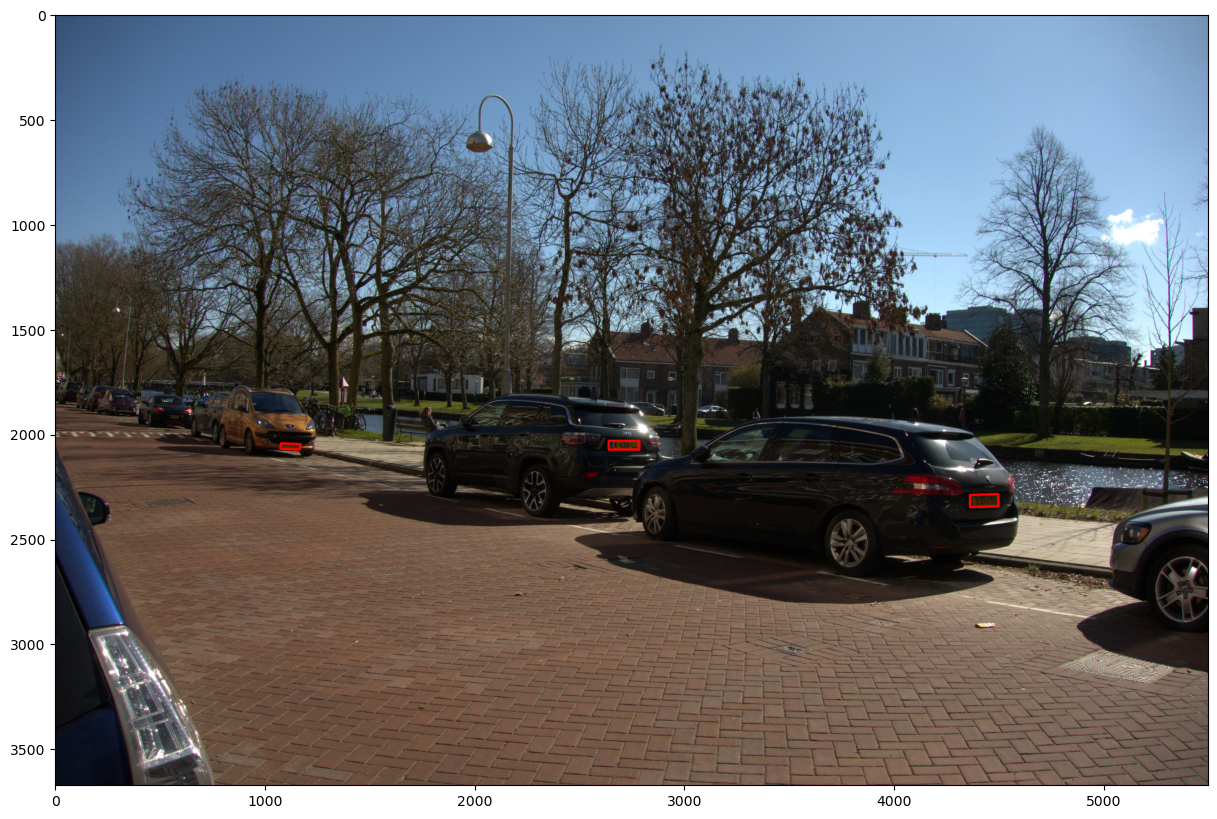

In [127]:
img_dir = '/home/niklas/projects/alpr-unconstrained/samples/oads_test/'
fig, ax = plt.subplots(1,1, figsize=(15,10))

for index, (name, list) in enumerate(license_plate_boxes.items()):
    if index < 3:
        continue
    img = np.array(Image.open(os.path.join(img_dir, f'{name}.JPG')))
    for box in list:
        # print(box)
        img, corners = draw_losangle(I=img,pts=box,color=(255,0,0),thickness=10)
        print(corners)
        # break
    
    ax.imshow(img)

    break